In [16]:
import os
import sys
import wandb
import argparse
import numpy as np


sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../")))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "")))
import torch
import torchvision.transforms as T
import torchvision

from dataloaders.dataloader_cifar10 import get_cifar10
from dataloaders.dataloader_cifar100 import get_cifar100
from utils.eval_metrics import linear_evaluation, get_t_SNE_plot
from models.linear_classifer import LinearClassifier
from models.ssl import  SimSiam, Siamese, Encoder, Predictor

from trainers.train_simsiam import train_simsiam
from trainers.train_infomax import train_infomax
from trainers.train_barlow import train_barlow

from trainers.train_PFR import train_PFR_simsiam
from trainers.train_PFR_contrastive import train_PFR_contrastive_simsiam
from trainers.train_contrastive import train_contrastive_simsiam
from trainers.train_ering import train_ering_simsiam

from torchsummary import summary
import random
from utils.lr_schedulers import LinearWarmupCosineAnnealingLR, SimSiamScheduler
from utils.eval_metrics import Knn_Validation_cont
from copy import deepcopy
from loss import invariance_loss,CovarianceLoss,ErrorCovarianceLoss
import torch.nn as nn
import time
import torch.nn.functional as F
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

In [2]:
class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[0.1, 2.0]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = torchvision.transforms.functional.gaussian_blur(x,kernel_size=[3,3],sigma=sigma)#kernel size and sigma are open problems but right now seems ok!
        return x


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

In [3]:
class Args():
    normalization = 'group'
    weight_standard = False
    same_lr = False
    pretrain_batch_size = 512
    pretrain_warmup_epochs = 10
    pretrain_warmup_lr = 3e-3
    pretrain_base_lr = 0.03
    pretrain_momentum = 0.9
    pretrain_weight_decay = 5e-4
    min_lr = 0.00
    lambdap = 1.0
    appr = 'barlow_PFR'
    knn_report_freq = 10
    cuda_device = 5
    num_workers = 8
    contrastive_ratio = 0.001
    dataset = 'cifar100'
    class_split = [25,25,25,25]
    epochs = [500,500,500,500]
    cov_loss_weight = 1.0
    sim_loss_weight = 250.0
    info_loss = 'invariance'
    lambda_norm = 1.0
    subspace_rate = 0.99
    lambda_param = 5e-3
    bsize = 32
    msize = 150
    proj_hidden = 2048
    proj_out = 2048 #infomax 64
    pred_hidden = 512
    pred_out = 2048



In [4]:
args = Args()

In [5]:
if args.dataset == "cifar10":
    get_dataloaders = get_cifar10
    num_classes=10
elif args.dataset == "cifar100":
    get_dataloaders = get_cifar100
    num_classes=100
assert sum(args.class_split) == num_classes
assert len(args.class_split) == len(args.epochs)

In [6]:
num_worker = args.num_workers
#device
device = torch.device("cuda:" + str(args.cuda_device) if torch.cuda.is_available() else "cpu")
print(device)

cuda:5


In [7]:
#wandb init
wandb.init(project="CSSL",  entity="yavuz-team",
            mode="disabled",
            config=args,
            name= str(args.dataset) + '-algo' + str(args.appr) + "-e" + str(args.epochs) + "-b" 
            + str(args.pretrain_batch_size) + "-lr" + str(args.pretrain_base_lr)+"-CS"+str(args.class_split))

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [8]:
if 'infomax' in args.appr or 'barlow' in args.appr:
    transform = T.Compose([
            T.RandomResizedCrop(size=32, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)]), p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([GaussianBlur()], p=0.5), 
            T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

    transform_prime = T.Compose([
            T.RandomResizedCrop(size=32, scale=(0.2, 1.0)),
            T.RandomHorizontalFlip(),
            T.RandomApply(torch.nn.ModuleList([T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)]), p=0.8),
            T.RandomGrayscale(p=0.2),
            T.RandomApply([GaussianBlur()], p=0.5), 
            T.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])])

In [9]:
#Dataloaders
print("Creating Dataloaders..")
#Class Based
train_data_loaders, train_data_loaders_knn, test_data_loaders, _, train_data_loaders_linear, train_data_loaders_pure  = get_dataloaders(transform, transform_prime, \
                                    classes=args.class_split, valid_rate = 0.00, batch_size=args.pretrain_batch_size, seed = 0, num_worker= num_worker)
_, train_data_loaders_knn_all, test_data_loaders_all, _, train_data_loaders_linear_all, train_data_loaders_pure_all = get_dataloaders(transform, transform_prime, \
                                        classes=[num_classes], valid_rate = 0.00, batch_size=args.pretrain_batch_size, seed = 0, num_worker= num_worker)


Creating Dataloaders..
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [10]:
device = torch.device("cuda:" + str(args.cuda_device) if torch.cuda.is_available() else "cpu")
print(device)
if 'infomax' in args.appr or 'barlow' in args.appr:
    proj_hidden = args.proj_hidden
    proj_out = args.proj_out
    encoder = Encoder(hidden_dim=proj_hidden, output_dim=proj_out, normalization = args.normalization, weight_standard = args.weight_standard,appr_name =args.appr)
    model = Siamese(encoder)
    model.to(device) #automatically detects from model

cuda:5


In [11]:
#load model here
file_name = 'checkpoints/checkpoint_cifar100-algocassle_barlow-e[500, 500, 500, 500]-b256-lr0.06-CS[25, 25, 25, 25]acc_62.57.pth.tar'
dict = torch.load(file_name)

In [12]:
model.temporal_projector = nn.Sequential(
            nn.Linear(args.proj_out, args.proj_hidden, bias=False),
            nn.BatchNorm1d(args.proj_hidden),
            nn.ReLU(),
            nn.Linear(args.proj_hidden, args.proj_out),
        ).to(device)

In [13]:
model.load_state_dict(dict['state_dict'])

<All keys matched successfully>

In [14]:
def total_performance(model, loaders):
    X = []
    y = []
    model.eval()
    with torch.no_grad():
        for task, loader in enumerate(loaders):
            for data_tuple in loader:
                data, target = [t.to(device) for t in data_tuple]
                output = model(data)
                X.append(output.cpu().numpy())
                y.append(target.cpu().numpy())

    X = np.concatenate(X)
    y = np.concatenate(y)
    clf = LinearSVC(random_state=0, tol=1e-5)
    clf.fit(X, y)
    return clf.score(X, y)

In [17]:
total_acc = total_performance(model, test_data_loaders)#Not real performance just shows the linear seperability
print(f'Total Performance of the model: {total_acc}')

Total Performance of the model: 0.9992


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [18]:
def train_clf(model, loader):
    X = []
    y = []
    model.eval()
    with torch.no_grad():
        for data_tuple in loader:
            data, target = [t.to(device) for t in data_tuple]
            # Forward prop of the model with single augmented batch
            output = model(data)
            X.append(output.cpu().numpy())
            y.append(target.cpu().numpy())
    X = np.concatenate(X)
    y = np.concatenate(y)
    clf = LinearSVC(random_state=0, tol=1e-5)
    clf.fit(X, y)
    return clf.score(X, y)

In [19]:
for task, loader in enumerate(test_data_loaders):
    acc = train_clf(model, loader)
    print(f"Task {task} Batch model acc: {acc*100:2f}")
    print()

Task 0 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 1 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 2 Batch model acc: 99.960000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 3 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [20]:
def train_task_seperation(model, loaders):
    X = []
    y = []
    model.eval()
    with torch.no_grad():
        for task, loader in enumerate(loaders):
            for (data, target) in loader:
                output = model(data.to(device))
                X.append(output.cpu().numpy())
                for k in range(len(target)):
                    y.append(task)

    X = np.concatenate(X)
    y = np.array(y)
    clf = LinearSVC(random_state=0, tol=1e-5)
    clf.fit(X, y)
    return clf.score(X, y)
            


In [21]:
task_seperability = train_task_seperation(model, test_data_loaders)
print(f'Task linear seperable performance: {task_seperability}')

Task linear seperable performance: 0.4659


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [22]:
#load model here
file_name = 'checkpoints/checkpoint_cifar100-algoLRD_barlow-e[500, 500, 500, 500]-b256-lr0.06-CS[25, 25, 25, 25]_task_0_lambdap_10.0_lambda_norm_0.1_same_lr_False_norm_batch_ws_False.pth.tar'
dict = torch.load(file_name)
device = torch.device("cuda:" + str(args.cuda_device) if torch.cuda.is_available() else "cpu")
print(device)
if 'infomax' in args.appr or 'barlow' in args.appr:
    proj_hidden = args.proj_hidden
    proj_out = args.proj_out
    encoder = Encoder(hidden_dim=proj_hidden, output_dim=proj_out, normalization = 'batch', weight_standard = args.weight_standard,appr_name =args.appr)
    old_model = Siamese(encoder)
    old_model.to(device) #automatically detects from model

old_model.load_state_dict(dict['state_dict'])

cuda:5


<All keys matched successfully>

In [23]:
total_acc = total_performance(old_model, test_data_loaders)#Not real performance just shows the linear seperability
print(f'Total Performance of the model: {total_acc}')

Total Performance of the model: 0.9995


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [24]:
for task, loader in enumerate(test_data_loaders):
    acc = train_clf(old_model, loader)
    print(f"Task {task} Batch model acc: {acc*100:2f}")
    print()

Task 0 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 1 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 2 Batch model acc: 99.960000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 3 Batch model acc: 100.000000



In [25]:
task_seperability = train_task_seperation(old_model, test_data_loaders)
print(f'Task linear seperable performance: {task_seperability}')

Task linear seperable performance: 0.5568


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [26]:
#load model here
file_name = 'checkpoints/checkpoint_cifar100-algoLRD_barlow-e[500, 500, 500, 500]-b256-lr0.06-CS[25, 25, 25, 25]_task_1_lambdap_10.0_lambda_norm_0.1_same_lr_False_norm_batch_ws_False.pth.tar'
dict = torch.load(file_name)
device = torch.device("cuda:" + str(args.cuda_device) if torch.cuda.is_available() else "cpu")
print(device)
if 'infomax' in args.appr or 'barlow' in args.appr:
    proj_hidden = args.proj_hidden
    proj_out = args.proj_out
    encoder = Encoder(hidden_dim=proj_hidden, output_dim=proj_out, normalization = 'batch', weight_standard = args.weight_standard,appr_name =args.appr)
    old_model = Siamese(encoder)
    old_model.to(device) #automatically detects from model

old_model.load_state_dict(dict['state_dict'])

cuda:5


<All keys matched successfully>

In [27]:
total_acc = total_performance(old_model, test_data_loaders)#Not real performance just shows the linear seperability
print(f'Total Performance of the model: {total_acc}')
for task, loader in enumerate(test_data_loaders):
    acc = train_clf(old_model, loader)
    print(f"Task {task} Batch model acc: {acc*100:2f}")
    print()

task_seperability = train_task_seperation(old_model, test_data_loaders)
print(f'Task linear seperable performance: {task_seperability}')


Total Performance of the model: 0.9997


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 0 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 1 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 2 Batch model acc: 99.960000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 3 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task linear seperable performance: 0.5643


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [28]:
#load model here
file_name = 'checkpoints/checkpoint_cifar100-algoLRD_barlow-e[500, 500, 500, 500]-b256-lr0.06-CS[25, 25, 25, 25]_task_2_lambdap_10.0_lambda_norm_0.1_same_lr_False_norm_batch_ws_False.pth.tar'
dict = torch.load(file_name)
device = torch.device("cuda:" + str(args.cuda_device) if torch.cuda.is_available() else "cpu")
print(device)
if 'infomax' in args.appr or 'barlow' in args.appr:
    proj_hidden = args.proj_hidden
    proj_out = args.proj_out
    encoder = Encoder(hidden_dim=proj_hidden, output_dim=proj_out, normalization = 'batch', weight_standard = args.weight_standard,appr_name =args.appr)
    old_model = Siamese(encoder)
    old_model.to(device) #automatically detects from model

old_model.load_state_dict(dict['state_dict'])

cuda:5


<All keys matched successfully>

In [29]:
total_acc = total_performance(old_model, test_data_loaders)#Not real performance just shows the linear seperability
print(f'Total Performance of the model: {total_acc}')
for task, loader in enumerate(test_data_loaders):
    acc = train_clf(old_model, loader)
    print(f"Task {task} Batch model acc: {acc*100:2f}")
    print()

task_seperability = train_task_seperation(old_model, test_data_loaders)
print(f'Task linear seperable performance: {task_seperability}')

Total Performance of the model: 0.9998


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 0 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 1 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 2 Batch model acc: 99.960000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 3 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task linear seperable performance: 0.5705


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [30]:
#load model here
file_name = 'checkpoints/checkpoint_cifar100-algoLRD_barlow-e[500, 500, 500, 500]-b256-lr0.06-CS[25, 25, 25, 25]_task_3_lambdap_10.0_lambda_norm_0.1_same_lr_False_norm_batch_ws_False.pth.tar'
dict = torch.load(file_name)
device = torch.device("cuda:" + str(args.cuda_device) if torch.cuda.is_available() else "cpu")
print(device)
if 'infomax' in args.appr or 'barlow' in args.appr:
    proj_hidden = args.proj_hidden
    proj_out = args.proj_out
    encoder = Encoder(hidden_dim=proj_hidden, output_dim=proj_out, normalization = 'batch', weight_standard = args.weight_standard,appr_name =args.appr)
    old_model = Siamese(encoder)
    old_model.to(device) #automatically detects from model

old_model.load_state_dict(dict['state_dict'])

cuda:5


<All keys matched successfully>

In [31]:
total_acc = total_performance(old_model, test_data_loaders)#Not real performance just shows the linear seperability
print(f'Total Performance of the model: {total_acc}')
for task, loader in enumerate(test_data_loaders):
    acc = train_clf(old_model, loader)
    print(f"Task {task} Batch model acc: {acc*100:2f}")
    print()

task_seperability = train_task_seperation(old_model, test_data_loaders)
print(f'Task linear seperable performance: {task_seperability}')

Total Performance of the model: 0.9997


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 0 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 1 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 2 Batch model acc: 99.960000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task 3 Batch model acc: 100.000000



/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Task linear seperable performance: 0.5753


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [30]:
#Test Linear classification acc
print("Starting Classifier Training..")
lin_epoch = 100
if args.dataset == 'cifar10':
    classifier = LinearClassifier(num_classes = 10).to(device)
elif args.dataset == 'cifar100':
    classifier = LinearClassifier(num_classes = 100).to(device)

classifier.load_state_dict(dict['classifier'])

lin_optimizer = torch.optim.SGD(classifier.parameters(), 0.1, momentum=0.9) # Infomax: no weight decay, epoch 100, cosine scheduler
lin_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(lin_optimizer, lin_epoch, eta_min=2e-4) #scheduler + values ref: infomax paper
test_loss, test_acc1, test_acc5, classifier = linear_evaluation(model, train_data_loaders_knn_all[0],
                                                                    test_data_loaders_all[0],lin_optimizer, classifier, 
                                                                    lin_scheduler, epochs=lin_epoch, device=device) 


Starting Classifier Training..


KeyError: 'classifier'

In [150]:
from tqdm import tqdm
def correct_top_k(outputs, targets, top_k=(1,5)):
    """
    Find number of correct predictions for one batch.
    Args:
        outputs (torch.Tensor): Nx(class_number) Tensor containing logits.
        targets (torch.Tensor): N Tensor containing ground truths.
        top_k (Tuple): checking the ground truth is included in top-k prediction.
    Returns:
        List: List of number of top-1 and top-5 correct predictions.
    """
    with torch.no_grad():
        prediction = torch.argsort(outputs, dim=-1, descending=True)
        result= []
        for k in top_k:
            correct_k = torch.sum((prediction[:, 0:k] == targets.unsqueeze(dim=-1)).any(dim=-1).float()).item() 
            result.append(correct_k)
        return result
def linear_test(net, data_loader, classifier, epoch, device):
    # evaluate model:
    net.eval() # for not update batchnorm
    linear_loss = 0.0
    num = 0
    total_loss, total_correct_1, total_correct_5, total_num, test_bar = 0.0, 0.0, 0.0, 0, tqdm(data_loader)
    with torch.no_grad():
        for data_tuple in test_bar:
            data, target = [t.to(device) for t in data_tuple]

            # Forward prop of the model with single augmented batch
            output = net(data)

            # Logits by classifier
            if classifier is not None:  #else net is already a classifier
                output = classifier(output) 

            # Calculate Cross Entropy Loss for batch
            linear_loss = F.cross_entropy(output, target)
            
            # Batchsize for loss and accuracy
            num = data.size(0)
            total_num += num 
            
            # Accumulating loss 
            total_loss += linear_loss.item() * num 
            # Accumulating number of correct predictions 
            correct_top_1, correct_top_5 = correct_top_k(output, target, top_k=(1,5))    
            total_correct_1 += correct_top_1
            total_correct_5 += correct_top_5

            test_bar.set_description('Lin.Test Epoch: [{}] Loss: {:.4f} ACC@1: {:.2f}% ACC@5: {:.2f}% '
                                     .format(epoch,  total_loss / total_num,
                                             total_correct_1 / total_num * 100, total_correct_5 / total_num * 100
                                             ))
        acc_1 = total_correct_1/total_num*100
        acc_5 = total_correct_5/total_num*100
        wandb.log({" Linear Layer Test Loss ": linear_loss / total_num, " Epoch ": epoch})
        wandb.log({" Linear Layer Test - Acc": acc_1, " Epoch ": epoch})
    return total_loss / total_num, acc_1 , acc_5 

In [151]:
def find_task(partition, c):
    total = 0
    for i in range(len(partition)):
        total += partition[i]
        if c < total:
            return i

def seperate_errors(net, data_loader, classifier, epoch, device, partition = [25,25,25,25]):
    # evaluate model:
    net.eval() # for not update batchnorm
    linear_loss = 0.0
    num = 0
    results = {}
    for i in range(len(partition)):
        results[i] = [0,0,0] #within task, inter-task, total 

    with torch.no_grad():
        for data_tuple in tqdm(data_loader):
            data, target = [t.to(device) for t in data_tuple]

            # Forward prop of the model with single augmented batch
            output = net(data)

            # Logits by classifier
            if classifier is not None:  #else net is already a classifier
                output = classifier(output) 

            prediction = torch.argsort(output, dim=-1, descending=True)
            prediction = prediction[:,0]
            print(prediction.shape)

            for i in range(len(target)):
                pred_task = find_task(partition, prediction[i])
                label_task = find_task(partition, target[i])

                results[label_task][2] += 1 # total
                if prediction[i] != target[i]:
                    if pred_task == label_task:
                        results[label_task][0] += 1 # within task
                    else:
                        results[label_task][1] += 1 # inter-task

        
    return results

In [152]:
def diameter_polytope(model, data_loader, device, classes = [0,1]):
    model.eval()
    latent_vectors = []
    with torch.no_grad():
        for data_tuple in tqdm(data_loader):
            data, target = [t.to(device) for t in data_tuple]
            output = model(data)
            for i in range(len(target)):
                if target[i] in classes:
                    latent_vectors.append(output[i].to('cpu'))

    #calculate diameter
    distances = []
    for i in range(len(latent_vectors)):
        for j in range(i):
            vec_1 = F.normalize(latent_vectors[i],dim=0)
            vec_2 = F.normalize(latent_vectors[j],dim=0)

            distance = torch.norm(vec_1 - vec_2)

            distances.append(distance)
            
    return max(distances), distances, latent_vectors



In [77]:
torch.arange(50)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])

In [86]:
diameter, distances, latent_vectors = diameter_polytope(model,test_data_loaders_all[0],device,classes = [0,25,50,75,99])

100%|██████████| 20/20 [00:04<00:00,  4.69it/s]


In [158]:
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
def gen_features(test_data_loader, net, classifier, device):
    net.eval()
    targets_list = []
    outputs_list = []

    #TODO: check if transform needed here?

    with torch.no_grad():
        for idx, (inputs, targets) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets_np = targets.data.cpu().numpy()

            feature = net(inputs)

            # Logits by classifier
            #outputs = classifier(feature) 
            #outputs_np = outputs.data.cpu().numpy()
            outputs_np = feature.cpu().numpy()
            
            targets_list.append(targets_np[:, np.newaxis])
            outputs_list.append(outputs_np)
            
            if ((idx+1) % 10 == 0) or (idx+1 == len(test_data_loader)):
                print(idx+1, '/', len(test_data_loader))

    targets = np.concatenate(targets_list, axis=0)
    outputs = np.concatenate(outputs_list, axis=0).astype(np.float64)

    return targets, outputs

def tsne_plot(targets, outputs, log_message, class_count):
    print('generating t-SNE plot...')
    # tsne_output = bh_sne(outputs)
    tsne = TSNE(random_state=0)
    tsne_output = tsne.fit_transform(outputs)

    df = pd.DataFrame(tsne_output, columns=['x', 'y'])
    df['targets'] = targets

    print(targets)
    plt.figure()
    plt.rcParams['figure.figsize'] = 10, 10
    sns.scatterplot(
        x='x', y='y',
        hue='targets',
        palette=sns.color_palette("hls", class_count), #10
        data=df,
        marker='o',
        legend="full",
        alpha=0.5
    )

    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')

    wandb.log({" t-SNE Plot "+log_message: [wandb.Image(plt)]})
    print('done!')

def get_t_SNE_plot(test_data_loader, encoder, classifier, device, log_message='global', class_count=10):
    #Code ref: https://github.com/2-Chae/PyTorch-tSNE/blob/main/main.py
    targets, outputs = gen_features(test_data_loader, encoder, classifier, device)
    #for i in range(targets.shape[0]):
    #    task = find_task([5,5],targets[i,0])
    #    targets[i,0] = task
    tsne_plot(targets, outputs, log_message=log_message, class_count=class_count)

10 / 20
20 / 20
generating t-SNE plot...


/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/duygu/anaconda3/envs/fedml_academic/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[[0]
 [0]
 [0]
 ...
 [9]
 [9]
 [9]]
done!


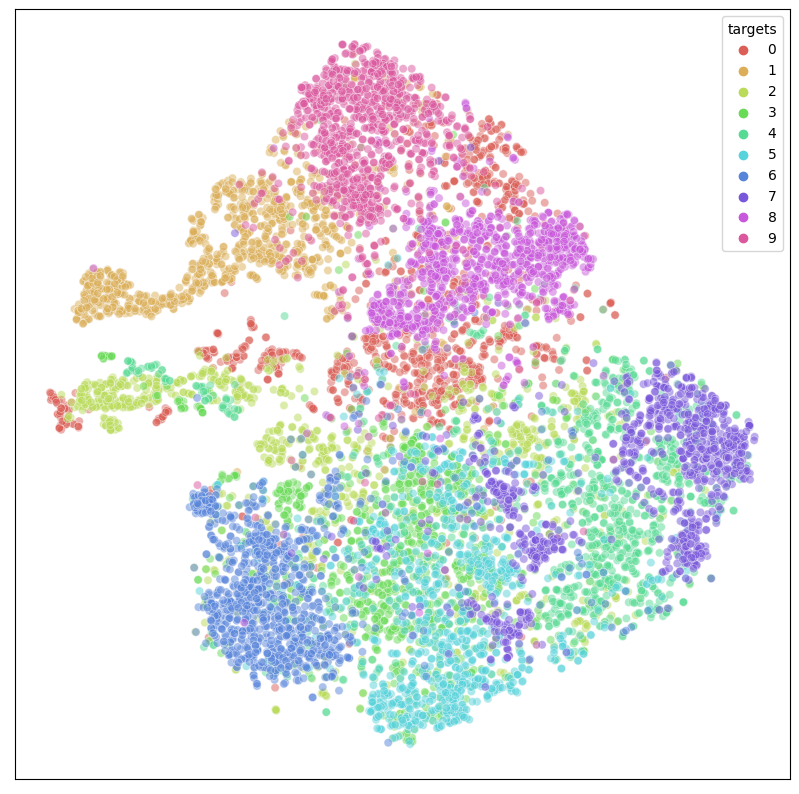

In [159]:
get_t_SNE_plot(test_data_loaders_all[0], model, classifier, device, class_count=10)

In [90]:
targets, outputs = gen_features(test_data_loaders_all[0], model, classifier, device)

10 / 20
20 / 20


In [45]:
model.eval()
linear_test(model,test_data_loaders_all[0],classifier,0,device)

Lin.Test Epoch: [0] Loss: 1.4469 ACC@1: 60.97% ACC@5: 85.99% : 100%|██████████| 20/20 [00:02<00:00,  7.12it/s]


(1.4469341033935548, 60.97, 85.99)

In [56]:
model.eval()
seperate_errors(model,test_data_loaders_all[0],classifier,0,device, partition = [25,25,25,25])

  5%|▌         | 1/20 [00:01<00:27,  1.44s/it]

torch.Size([512])
torch.Size([512])


 15%|█▌        | 3/20 [00:01<00:06,  2.45it/s]

torch.Size([512])
torch.Size([512])


 25%|██▌       | 5/20 [00:01<00:03,  4.48it/s]

torch.Size([512])
torch.Size([512])


 35%|███▌      | 7/20 [00:02<00:02,  5.75it/s]

torch.Size([512])
torch.Size([512])


 45%|████▌     | 9/20 [00:02<00:01,  6.36it/s]

torch.Size([512])
torch.Size([512])


 55%|█████▌    | 11/20 [00:02<00:01,  6.38it/s]

torch.Size([512])
torch.Size([512])


 65%|██████▌   | 13/20 [00:03<00:01,  6.28it/s]

torch.Size([512])
torch.Size([512])


 75%|███████▌  | 15/20 [00:03<00:00,  6.57it/s]

torch.Size([512])
torch.Size([512])


 85%|████████▌ | 17/20 [00:03<00:00,  6.38it/s]

torch.Size([512])
torch.Size([512])


 95%|█████████▌| 19/20 [00:03<00:00,  6.54it/s]

torch.Size([512])
torch.Size([272])


100%|██████████| 20/20 [00:04<00:00,  4.66it/s]


{0: [256, 727, 2500],
 1: [292, 747, 2500],
 2: [298, 658, 2500],
 3: [177, 748, 2500]}

In [57]:
(256 + 727)/2500

0.3932

In [59]:
177 * 3

531